In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.core.display import Image
from sklearn.model_selection import train_test_split
from torchvision import models
from torch.utils.data import Dataset, DataLoader, default_collate
import numpy as np
import pandas as pd
import os
import cv2 as cv
from torchvision.transforms import AutoAugmentPolicy, InterpolationMode


In [2]:
#train_folder = r"/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train"
train_folder = r"C:/Users/alito/OneDrive/Desktop/Dersler/Computer_Vision/Group_Assignment2/train"

# preprocess
train_df = pd.read_csv(os.path.join(train_folder, 'train_set.csv'), index_col="Id")
labels_cols = list(train_df.columns)
train_df["img"] = [np.load(os.path.join(train_folder, 'img/train_{}.npy'.format(idx))) for idx, _ in train_df.iterrows()]

all_labled_X = train_df.loc[:, ["img"]]
all_labled_Y = train_df.loc[:, labels_cols]

X_train, X_test, y_train, y_test = train_test_split(all_labled_X, all_labled_Y, test_size=0.2, random_state=100)

XY_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
XY_test = pd.merge(X_test, y_test, left_index=True, right_index=True)


In [3]:
XY_test.iloc[0]

img            [[[25, 51, 40], [30, 49, 43], [31, 47, 44], [2...
aeroplane                                                      0
bicycle                                                        0
bird                                                           0
boat                                                           0
bottle                                                         0
bus                                                            0
car                                                            0
cat                                                            0
chair                                                          0
cow                                                            1
diningtable                                                    0
dog                                                            0
horse                                                          0
motorbike                                                      0
person                   

In [4]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")



C:\Users\alito\anaconda3\envs\computervision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
C:\Users\alito\anaconda3\envs\computervision\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alito\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, 

In [6]:
np.zeros_like(labels_cols, dtype=np.uint8)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [7]:
def array_to_lables(x):
    for i in range(len(x)):
        is_lable = int(x[i])
        if is_lable:
            print(labels_cols[i])

def timshow(x):
    plt.imshow(transforms.ToPILImage()(x))

# dataloader
class ImagesDataset(Dataset):
    def __init__(self, dataframe, transform=None, img_col="img", lable_cols=labels_cols):
        """
        :param dataframe: dataframe with column named "img" containgin the image
        """
        self.df = dataframe
        self.transform = transform
        self.img_col = img_col
        self.lable_cols = labels_cols

    def __getitem__(self, item):
        img = self.df.iloc[item][self.img_col]
        lables = np.array(list(self.df.iloc[item][self.lable_cols]), dtype=np.float32)
        if self.transform:
            img = self.transform(img)
            # checking if the retruend images are batched
            if len(img.shape) == 4:
                # return batched lables as well
                lables = np.tile(lables, img.shape[0]).reshape(img.shape[0], -1)
        return img, lables

    def __len__(self):
        # note the len only returns the number of raw images but not the augmented ones!!
        return len(self.df)


In [26]:
def classify_one_image(image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    print([1, image.shape[0], image.shape[1]])
    print(np.shape(outputs))
    target_sizes = torch.tensor([1, image.shape[0], image.shape[1]])
    
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
    lbls = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#         box = [round(i, 2) for i in box.tolist()]
        lbls.append(model.config.id2label[label.item()])
#         print(
#                 f"Detected {model.config.id2label[label.item()]} with confidence "
#                 f"{round(score.item(), 3)} at location {box}"
#         )
    return set(lbls)

def create_lbl_array(lbls, labels_cols):
    labels_cols = labels_cols.copy()
    labels_cols[0] = "airplane"
    labels_cols[10] = "dining table"
    labels_cols[13] = "motorcycle"
    labels_cols[15] = "potted plant"
    labels_cols[19] = "tv"
    out = np.zeros_like(labels_cols, dtype=np.uint8)
    for i in range(len(labels_cols)):
        if labels_cols[i] in lbls:
            out[i] = 1
    return out

In [8]:
print(labels_cols)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


[1, 375, 500]
()


ValueError: Make sure that you pass in as many target sizes as the batch dimension of the logits

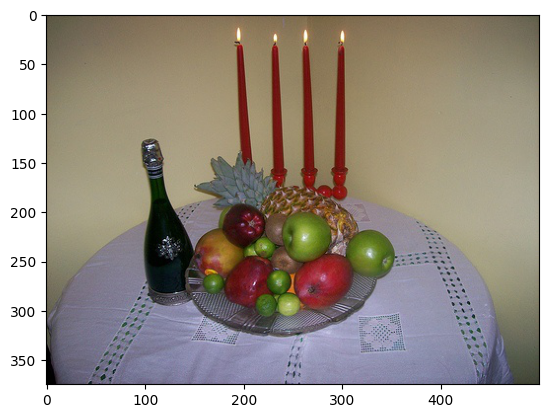

In [27]:
im = XY_test.iloc[10]['img']
plt.imshow(im)
lbls = classify_one_image(im)
create_lbl_array(lbls, labels_cols)

In [92]:
batch_size = 1
train_XY_dataset = ImagesDataset(XY_train, lable_cols=labels_cols)
train_XY_dataloader = DataLoader(dataset=train_XY_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)


test_XY_dataset = ImagesDataset(XY_test, lable_cols=labels_cols)
test_XY_dataloader = DataLoader(dataset=test_XY_dataset, batch_size=batch_size, shuffle=False,  collate_fn=lambda x: x)


In [95]:
train_XY_dataset[0]

(array([[[254, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [251, 255, 254],
         [250, 253, 255],
         [255, 255, 250]],
 
        [[ 60,  73, 115],
         [ 60,  73, 115],
         [ 60,  73, 115],
         ...,
         [ 53,  57,  95],
         [102, 105, 136],
         [253, 253, 255]],
 
        [[ 28,  44,  96],
         [ 28,  44,  95],
         [ 27,  43,  94],
         ...,
         [  8,  18,  71],
         [ 56,  61, 101],
         [254, 255, 255]],
 
        ...,
 
        [[116,  92,  80],
         [ 72,  80,  59],
         [123, 133, 108],
         ...,
         [119, 116, 109],
         [187, 178, 171],
         [255, 254, 253]],
 
        [[161, 161, 149],
         [133, 133, 121],
         [140, 136, 125],
         ...,
         [122, 118, 115],
         [154, 153, 151],
         [254, 252, 253]],
 
        [[255, 255, 255],
         [255, 253, 254],
         [255, 253, 254],
         ...,
         [255, 254, 252],
  

In [78]:
labels[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [116]:
    dataloader = test_XY_dataloader
# def eval_model(model, dataloader ):
    # evaluation
    true_lables = []
    predicted_lables =[]
    pred_images = []

    print("start eval")
    with torch.no_grad():
        
        for i,data  in enumerate(dataloader):
            data = np.array(data, dtype=object)
            images = data[:, 0]
            labels = data[:, 1]
            images = images[0]
            labels = labels[0]

            lbls = classify_one_image(images)
            pred = create_lbl_array(lbls, labels_cols)
            # if in cuda, remove from it so it will be possible to call numpy
#             if outputs.is_cuda:
#                 outputs = outputs.cpu()
#             if lables.is_cuda:
#                 lables = lables.cpu()
                
            predicted_lables.append(pred)
            true_lables.append(labels)
            pred_images.append(images)
            
            
    #
    # x = 144
    # plt.imshow(transforms.ToPILImage()(pred_images[x]))
    # array_to_lables(predicted_lables[x])
    # array_to_lables(true_lables[x])

    exact_match = 0
    for i in range(len(true_lables)):
        if np.array_equal(predicted_lables[i], true_lables[i]):
#             print(i)
#             print(array_to_lables(predicted_lables[i]))
            exact_match +=1
        else:
            print(i)
    print(f"MODEL EVAL exact match {exact_match}/{len(predicted_lables)}")



start eval
1
5
6
7
9
13
20
21
23
26
28
35
37
43
47
51
59
62
63
66
67
71
72
73
81
85
86
87
90
91
92
94
99
107
108
114
118
120
122
124
130
136
137
143
145
146
148
MODEL EVAL exact match 103/150


person
tvmonitor
None
person
sofa
tvmonitor
None


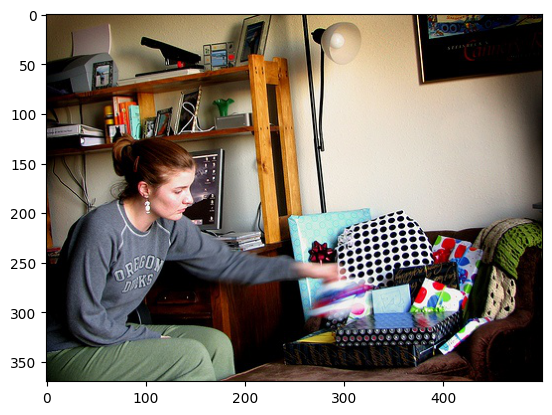

In [120]:
k = 136
plt.imshow(pred_images[k])
print(array_to_lables(predicted_lables[k]))
print(array_to_lables(true_lables[k]))
